In [1]:
import os
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from keras.models import model_from_json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = np.dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

def Lr(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [4]:
save_dir_mfcc   = 'C:/Users/NITM/home_automation/ensemble_learning/'
x1              = joblib.load(save_dir_mfcc  + 'mfcc_xtest.joblib')
y1              = joblib.load(save_dir_mfcc  + 'mfcc_ytest.joblib')

In [5]:
save_dir_emd    = 'C:/Users/NITM/home_automation/ensemble_learning/'
x2              = joblib.load(save_dir_mfcc  + 'emd_xtest.joblib')
y2              = joblib.load(save_dir_mfcc  + 'emd_ytest.joblib')

In [6]:
y1_ohe =  tf.keras.utils.to_categorical(y1)
y2_ohe =  tf.keras.utils.to_categorical(y2)

In [7]:
model_list1=[]
model_list2=[]

In [8]:
model_path1='C:/Users/NITM/home_automation/ensemble_learning/mfcc_weights'
model_li1=os.listdir(model_path1)
model_li1

['100', '190', '203', '225', '243']

In [9]:
model_path2='C:/Users/NITM/home_automation/ensemble_learning/emd_weights'
model_li2=os.listdir(model_path2)
model_li2

['102', '106', '119', '193', '203']

In [10]:
for fol in model_li1:
    path=os.path.join(model_path1,fol)
    li=os.listdir(path)
    j=[_ for _ in li if _.endswith(".json")]
    w=[_ for _ in li if _.endswith(".h5")]
    
    json_file = open(path+"/"+j[0], 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path+"/"+w[0])
    model_list1.append(loaded_model)   

In [11]:
for fol in model_li2:
    path=os.path.join(model_path2,fol)
    li=os.listdir(path)
    j=[_ for _ in li if _.endswith(".json")]
    w=[_ for _ in li if _.endswith(".h5")]
    
    json_file = open(path+"/"+j[0], 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path+"/"+w[0])
    model_list2.append(loaded_model)   

In [12]:
for i in range(0,len(model_list1)):
    model_list1[i].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_list2[i].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
his0=model_list1[0].evaluate(x1,y1_ohe)
his1=model_list1[1].evaluate(x1,y1_ohe)
his2=model_list1[2].evaluate(x1,y1_ohe)
his3=model_list1[3].evaluate(x1,y1_ohe)
his4=model_list1[4].evaluate(x1,y1_ohe)

7/7 [==============================] - 0s 9ms/step - loss: 0.6863 - accuracy: 0.8626


In [14]:
his0=model_list2[0].evaluate(x2,y2_ohe)
his1=model_list2[1].evaluate(x2,y2_ohe)
his2=model_list2[2].evaluate(x2,y2_ohe)
his3=model_list2[3].evaluate(x2,y2_ohe)
his4=model_list2[4].evaluate(x2,y2_ohe)

7/7 [==============================] - 0s 13ms/step - loss: 0.8406 - accuracy: 0.7915


In [15]:
model2=Lr(model_list2,x2,y2)

In [17]:
# evaluate model on test set
yhat2 = stacked_prediction(model_list2, model2, x2)
acc2 = accuracy_score(y2, yhat2)
print('Stacked Test Accuracy: %.3f' % acc2)

Stacked Test Accuracy: 0.872


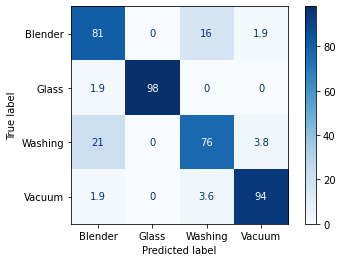

In [18]:
cm2=confusion_matrix(y2,yhat2)
cm2=(cm2/cm2.astype(np.float64).sum(axis=1))*100

from sklearn.metrics import ConfusionMatrixDisplay
labels = ["Blender","Glass","Washing","Vacuum"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
model1=Lr(model_list1,x1,y1)

In [22]:
# evaluate model on test set
yhat1 = stacked_prediction(model_list1, model1, x1)
acc1 = accuracy_score(y1, yhat1)
print('Stacked Test Accuracy: %.3f' % acc1)

Stacked Test Accuracy: 0.924


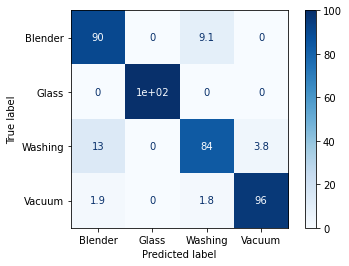

In [24]:
cm1=confusion_matrix(y1,yhat1)
cm1=(cm1/cm1.astype(np.float64).sum(axis=1))*100

from sklearn.metrics import ConfusionMatrixDisplay
labels = ["Blender","Glass","Washing","Vacuum"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [34]:
model_list3=[]
model_list3.append(model_list2[1])
model_list3.append(model_list1[1])
yhat3_1=model_list3[0].predict(x2)#emd  .815
yhat3_2=model_list3[1].predict(x1)#mfcc .905
stackX = np.dstack((yhat3_1, yhat3_2))
stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
stackX = np.dstack((yhat3_1, yhat3_2))
stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
model_x = LogisticRegression()
model_x.fit(stackX,y1)
res=model_x.predict(stackX)
acc3 = accuracy_score(y2, res)
print('Stacked Test Accuracy: %.3f' % acc3)

Stacked Test Accuracy: 0.915


In [35]:
model_list3=[]

model_list3.append(model_list2[1])
model_list3.append(model_list1[1])
model_list3.append(model_list2[3])

yhat3_1=model_list3[0].predict(x2)#emd  .815
yhat3_2=model_list3[1].predict(x1)#mfcc .905
yhat3_3=model_list3[2].predict(x2)#emd .806


stackX = np.dstack((yhat3_1, yhat3_2))
stackX = np.dstack((stackX, yhat3_3))


stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
model_x = LogisticRegression()
model_x.fit(stackX,y1)
res=model_x.predict(stackX)
acc3 = accuracy_score(y2, res)
print('Stacked Test Accuracy: %.3f' % acc3)

Stacked Test Accuracy: 0.924


In [36]:
model_list3=[]

model_list3.append(model_list2[1])
model_list3.append(model_list1[1])
model_list3.append(model_list2[3])
model_list3.append(model_list2[4])

yhat3_1=model_list3[0].predict(x2)#emd  .815
yhat3_2=model_list3[1].predict(x1)#mfcc .905
yhat3_3=model_list3[2].predict(x2)#emd .806
yhat3_4=model_list3[2].predict(x2)#emd .79


stackX = np.dstack((yhat3_1, yhat3_2))
stackX = np.dstack((stackX, yhat3_3))
stackX = np.dstack((stackX, yhat3_4))


stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
model_x = LogisticRegression()
model_x.fit(stackX,y1)
res=model_x.predict(stackX)
acc3 = accuracy_score(y2, res)
print('Stacked Test Accuracy: %.3f' % acc3)

Stacked Test Accuracy: 0.929


In [38]:
model_list3=[]

model_list3.append(model_list2[1])
model_list3.append(model_list1[1])
model_list3.append(model_list2[3])
model_list3.append(model_list2[4])
model_list3.append(model_list1[0])

yhat3_1=model_list3[0].predict(x2)#emd  .815
yhat3_2=model_list3[1].predict(x1)#mfcc .905
yhat3_3=model_list3[2].predict(x2)#emd .806
yhat3_4=model_list3[3].predict(x2)#emd .79
yhat3_5=model_list3[4].predict(x1)#mfcc .87



stackX = np.dstack((yhat3_1, yhat3_2))
stackX = np.dstack((stackX, yhat3_3))
stackX = np.dstack((stackX, yhat3_4))
stackX = np.dstack((stackX, yhat3_5))


stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
model_x = LogisticRegression()
model_x.fit(stackX,y1)
res=model_x.predict(stackX)
acc3 = accuracy_score(y2, res)
print('Stacked Test Accuracy: %.3f' % acc3)

Stacked Test Accuracy: 0.924


Stacked Test Accuracy: 0.915
